<a href="https://colab.research.google.com/github/tevfikcagridural/Steel_Defect_Detection/blob/main/Capstone_3_Modelling_With_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/tensorflow/models/blob/fab47e9e105d3cc98fc04cf172fa2038607d0939/research/object_detection/g3doc/tf2_detection_zoo.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pathlib
import shutil


# Copy data from google drive
zip_train = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/train_images.zip')
zip_test = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/test_images.zip')
zip_train_csv = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/train.csv.zip')

dest = pathlib.Path('/content/')

shutil.copy(zip_train, dest)
shutil.copy(zip_test, dest)
shutil.copy(zip_train_csv, dest)


'/content/train.csv.zip'

In [4]:
import zipfile

# Unzip images
zipfile_train = 'train_images.zip'
zipfile_test = 'test_images.zip'

with zipfile.ZipFile(zipfile_train) as ztr:
  ztr.extractall('train_images')

with zipfile.ZipFile(zipfile_test) as zte:
  zte.extractall('test_images')

# Load images

In [5]:
# Split images based on their defect types
train_csv = pd.read_csv("/content/train.csv.zip", dtype=str)

In [6]:
SEED = 42
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
TARGET_SIZE =  (160, 160) #(1024, 1024)

In [7]:
train_datagen = ImageDataGenerator(validation_split=0.25)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)

Found 5322 validated image filenames belonging to 4 classes.
Found 1773 validated image filenames belonging to 4 classes.


In [8]:
test_datagen = ImageDataGenerator()

## TODO: create your own test split

Found 0 images belonging to 0 classes.


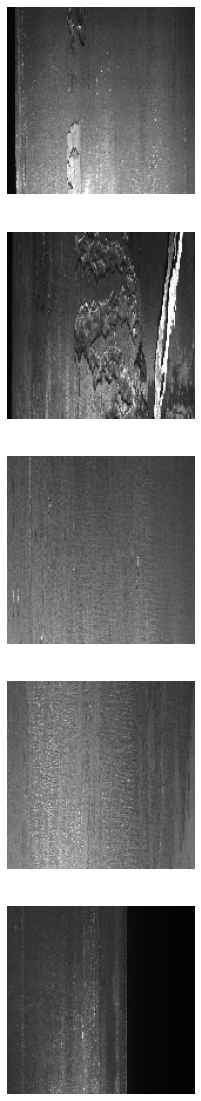

In [9]:
class_names = train_generator.class_indices

## TODO: resize images back to original before plotting
## TODO: plot with image labels

plt.figure(figsize=(20, 20))

for col in iter(train_generator):
  images, labels = col
  for i in range(5):
    ax = plt.subplot(5, 1, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
  break

# Modelling MobileNetV2

In [10]:
# To rescale the values between [-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## TODO: Apply more augmentations 
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
INPUT_SHAPE = (160, 160, 3) #TARGET_SIZE + (3, ) 
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_generator)

56/56 [==============================] - 43s 726ms/step - loss: 1.9651 - accuracy: 0.0958


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.98
initial accuracy: 0.10


In [23]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/10
167/167 [==============================] - 174s 1s/step - loss: 0.9986 - accuracy: 0.6667 - val_loss: 0.9483 - val_accuracy: 0.6560
Epoch 2/10
167/167 [==============================] - 170s 1s/step - loss: 0.8103 - accuracy: 0.7197 - val_loss: 0.8307 - val_accuracy: 0.6988
Epoch 3/10
167/167 [==============================] - 169s 1s/step - loss: 0.7288 - accuracy: 0.7339 - val_loss: 0.7669 - val_accuracy: 0.7095
Epoch 4/10
167/167 [==============================] - 169s 1s/step - loss: 0.6887 - accuracy: 0.7394 - val_loss: 0.7430 - val_accuracy: 0.7101
Epoch 5/10
167/167 [==============================] - 168s 1s/step - loss: 0.6520 - accuracy: 0.7467 - val_loss: 0.6998 - val_accuracy: 0.7259
Epoch 6/10
167/167 [==============================] - 169s 1s/step - loss: 0.6439 - accuracy: 0.7493 - val_loss: 0.6794 - val_accuracy: 0.7343
Epoch 7/10
167/167 [==============================] - 170s 1s/step - loss: 0.6204 - accuracy: 0.7493 - val_loss: 0.6629 - val_accuracy: 0.7310

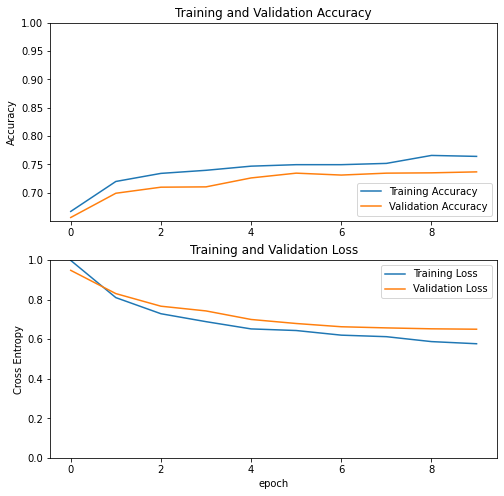

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine tuning

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [27]:
fine_tune_at = 100

In [28]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 10/20
167/167 [==============================] - 248s 1s/step - loss: 0.5959 - accuracy: 0.7610 - val_loss: 0.7101 - val_accuracy: 0.7360
Epoch 11/20
167/167 [==============================] - 239s 1s/step - loss: 0.5086 - accuracy: 0.7982 - val_loss: 0.6144 - val_accuracy: 0.7383
Epoch 12/20
167/167 [==============================] - 246s 1s/step - loss: 0.4869 - accuracy: 0.7978 - val_loss: 0.7740 - val_accuracy: 0.7372
Epoch 13/20
167/167 [==============================] - 241s 1s/step - loss: 0.4783 - accuracy: 0.7960 - val_loss: 0.5633 - val_accuracy: 0.7648
Epoch 14/20
167/167 [==============================] - 240s 1s/step - loss: 0.4478 - accuracy: 0.8181 - val_loss: 0.6996 - val_accuracy: 0.7332
Epoch 15/20
167/167 [==============================] - 242s 1s/step - loss: 0.4452 - accuracy: 0.8075 - val_loss: 0.5555 - val_accuracy: 0.7665
Epoch 16/20
167/167 [==============================] - 244s 1s/step - loss: 0.4425 - accuracy: 0.8244 - val_loss: 0.6098 - val_accuracy:

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


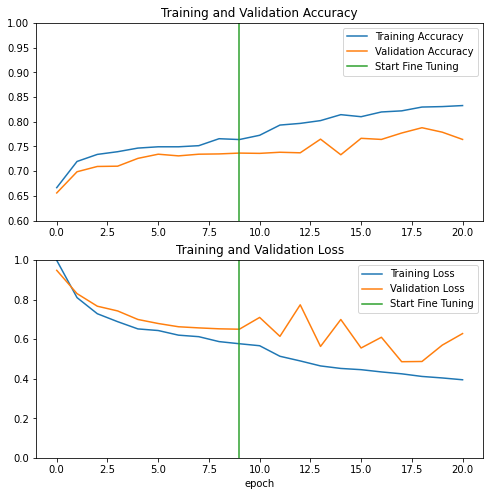

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
## TODO: Get confusion matrix

In [35]:
image_batch, label_batch = next(iter(train_generator))

In [36]:
predictions = model.predict_on_batch(image_batch).flatten()

In [37]:
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(9):
  ax = plt.subplot(9, 1, i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])
  plt.axis('off')

In [ ]:
image_batch[1]